## Planet: Understanding the Amazon from Space 🌳🛰️
#### Use satellite data to track the human footprint in the Amazon rainforest

#### Processing steps:
part 1: EDA and data pre-processing - previous notebook <br>
part 2: Baseline model 

1. Feature engineering
2. Stratified training/validation data split
3. Classification
4. Accuracy assessment

part 3: PyTorch CNN models - next notebook <br>

#### Sources: 
[1] Scikit-learn documentation. Section 1.12.3. Multiclass-multioutput classification https://scikit-learn.org/stable/modules/multiclass.html#multiclass-multioutput-classification <br>
[2] Kaggle competiton *Planet: Understanding the Amazon from Space*, section Overview: https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/overview <br>

### Step 0: Importing packages

In [1]:
import glob
import os
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
import earthpy.plot as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from skimage.feature import local_binary_pattern
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder

#### Idea behind the baseline model:

The nature of the problem which can basically be defined as finding specific classes within the image chip, suggests that it is not an easy task. One can guess that it can probably be solved most accurately using approaches involving CNN or ViT. The implementation of CNN will be presented in the next notebook. Before building such a model, I however decided to create a baseline - a straightforward model built using faster-running *'classical'* ML/CV methods. The baseline model will not include any customized feature engineering, hyperparameter tuning or class balancing strategies. The experiments will be limited to testing:
- 3 algorithms: Logistic Regression, Random Forest, kNN;
- 2 Scikit-learn's wrapper methods: MultiOutputClassifier (trains one independent classifier for each output variable [1]) and ClassifierChain (exploits dependencies between outputs [1]).

(In fact, after an initial test I decided to skip the approach with Logistic Regression wrapped using ClassifierChain. The approach turned out to be extremely slow, needing a lot of iterations to converge.)

Measuring differences in the computation time and achieved accuracy of the two approaches - baseline and CNN will allow me to decide which one is better and to what extent. 

The table below will show the metrics for each of the tested baseline approaches (run of a 10-core CPU):

In [3]:
baseline_metrics_df = pd.DataFrame(np.zeros((5, 4)), 
                                   columns=['fe_color_time [min]', 'fe_texture_time [min]', 'train_time [min]', 'pred_time [min]'], 
                                   index=['MOC Logistic Regression', 'MOC Random Forest', 'MOC kNN', 
                                          'CC Random Forest', 'CC kNN'])

In [4]:
baseline_metrics_df

,fe_color_time [min],fe_texture_time [min],train_time [min],pred_time [min]
MOC Logistic Regression,0.0,0.0,0.0,0.0
MOC Random Forest,0.0,0.0,0.0,0.0
MOC kNN,0.0,0.0,0.0,0.0
CC Random Forest,0.0,0.0,0.0,0.0
CC kNN,0.0,0.0,0.0,0.0


### Step 1: Feature engineering

When flattening an image from the training set, each sample would have 256x256x3 features (each pixel value is treated as a feature). This is a huge number, so using the original image would most probably lead to the curse of dimensionality. In order to omit this problem, some dimensionality reduction is needed. I decided to follow two fundamental assumptions:
- new features should describe the image without relation to a specific place in the image - objects being classified may occur anywhere in the image,
- spectral reflectance (color) and texture are the most important characteristics that should be addressed.

I decided that 25-bin color and texture histogram values will provide the needed size reduction and global data characterization. Of course, more sophisticated approaches exist e.g. Bag-of-Visual-Words (BoVW). They would probably work much better, but I was mostly interested in checking the performance of the simpler methods when creating a baseline model.

<b> 1.1. PCA color histogram </b>

In [5]:
jpg_data_path = 'planets-dataset/planet/planet/train-jpg/'

In [6]:
input_images = glob.glob(jpg_data_path + '*_flipped.jpg')

In [7]:
image_id_dict = dict(enumerate([os.path.basename(ii)[:-12] for ii in input_images])) # to match feature reducted np.Arrays to image names

In [8]:
with open('image_id_dict.pickle', 'wb') as file:
    pickle.dump(image_id_dict, file)

In [9]:
def calculate_1iPCA_for_RGB_images(input_paths:list, fit_perc=0.05) -> list:
    """Returns a list of np.arrays - flattened 1st iPCA components."""
    
    fit_size = int(len(input_paths) * fit_perc)
    print(f"iPCA will be fitten using {fit_size} input images")
    
    # fitting iPCA
    iPCA = IncrementalPCA(n_components=1)
    for i in range(fit_size):
        curr_img_na = np.array(Image.open(input_paths[i])).reshape(-1, 3)
        iPCA.partial_fit(curr_img_na)
        if i%100==0:
            print(f"{i}th input image fitted")
    print(f"The explained variance ratio is: {iPCA.explained_variance_ratio_}")
    
    # transforming images using iPCA object
    flattened_ipca = []
    for i in range(len(input_paths)):
        curr_img_na = np.array(Image.open(input_paths[i])).reshape(-1, 3)
        curr_pca_na = iPCA.transform(curr_img_na)
        flattened_ipca.append(curr_pca_na.reshape(1, -1))
        if len(flattened_ipca)%1000==0:
            print(f"{len(flattened_ipca)} / {len(input_paths)} images transformed") 
    return flattened_ipca

In [10]:
start_time = time.time()
ipca_train_images = calculate_1iPCA_for_RGB_images(input_images)
end_time = time.time()
baseline_metrics_df['fe_color_time [min]'] = round((end_time - start_time)/60, 2)

iPCA will be fitten using 2023 input images
0th input image fitted
100th input image fitted
200th input image fitted
300th input image fitted
400th input image fitted
500th input image fitted
600th input image fitted
700th input image fitted
800th input image fitted
900th input image fitted
1000th input image fitted
1100th input image fitted
1200th input image fitted
1300th input image fitted
1400th input image fitted
1500th input image fitted
1600th input image fitted
1700th input image fitted
1800th input image fitted
1900th input image fitted
2000th input image fitted
The explained variance ratio is: [0.97681302]
1000 / 40479 images transformed
2000 / 40479 images transformed
3000 / 40479 images transformed
4000 / 40479 images transformed
5000 / 40479 images transformed
6000 / 40479 images transformed
7000 / 40479 images transformed
8000 / 40479 images transformed
9000 / 40479 images transformed
10000 / 40479 images transformed
11000 / 40479 images transformed
12000 / 40479 images t

In [11]:
def calculate_histogram_for_listed_arrays(input_listed_array:list, n_bins=25) -> np.array:
    """Returns a np.array with each image's 1st iPCA component histogram values."""
    
    # histogram definition
    min_value, max_value = min([np.min(arr) for arr in input_listed_array]), max([np.max(arr) for arr in input_listed_array])
    bin_edges = np.linspace(min_value, max_value, n_bins + 1)
    
    # histogram values calculation
    histograms_na = np.zeros((len(input_listed_array), n_bins))
    for i, arr in enumerate(input_listed_array):
        histograms_na[i, :] = np.histogram(arr, bins=bin_edges)[0]
    histograms_na = histograms_na.astype(int)
    return histograms_na

In [12]:
start_time = time.time()
ipca_train_histograms_na = calculate_histogram_for_listed_arrays(ipca_train_images)
end_time = time.time()
baseline_metrics_df['fe_color_time [min]'] += round((end_time - start_time)/60, 2)

In [13]:
with open('color_histogram_na.npy', 'wb') as f:
    np.save(f, ipca_train_histograms_na, allow_pickle=False)

We can visualize the results for the first sample:

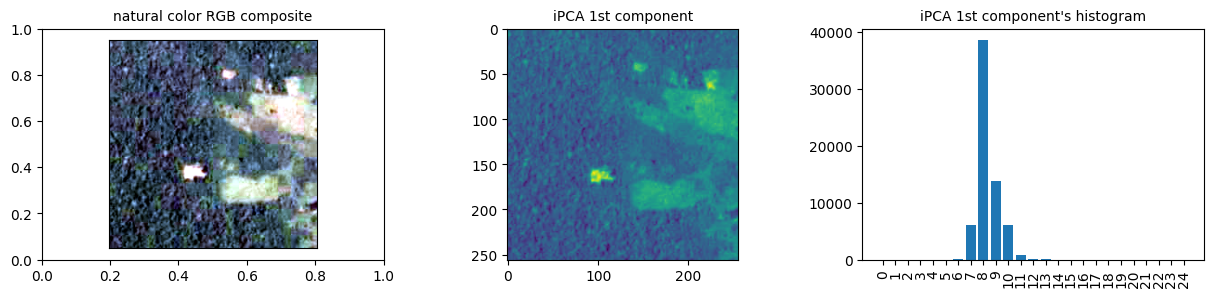

In [14]:
rows = 1
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15,3))

# ax0 
image_na = np.array(Image.open(input_images[0]))
image_na = np.moveaxis(image_na, [2], [0])
ep.plot_rgb(image_na, rgb=(0, 1, 2), ax=axes[0].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True)
axes[0].set_title('natural color RGB composite', fontsize=10)

# ax1
ipca_na = ipca_train_images[0].reshape(256, 256)
axes[1].imshow(ipca_na, cmap='viridis')
axes[1].set_title('iPCA 1st component', fontsize=10)

# ax2

axes[2].bar(['bin ' + str(i) for i in range(25)], ipca_train_histograms_na[0,:])
axes[2].set_xticklabels(axes[2].get_xticks(), rotation = 90)
axes[2].set_title("iPCA 1st component's histogram", fontsize=10)

plt.show();

<b> 1.2. Local Binary Pattern (LBP) histogram </b>

In [15]:
def calculate_LBP_for_RGB_images(input_paths:list) -> list:
    """Returns a list of np.arrays - flattened LBP values."""
    
    flattened_lbp = []
    for i in range(len(input_paths)):
        curr_grey_na = np.mean(np.array(Image.open(input_paths[i])), axis=2).astype('uint8')
        curr_lbp_na = local_binary_pattern(curr_grey_na, 8, 3, 'uniform')
        flattened_lbp.append(curr_lbp_na.reshape(1, -1))
        if len(flattened_lbp)%1000==0:
            print(f"{len(flattened_lbp)} / {len(input_paths)} images transformed")
    return flattened_lbp

In [16]:
start_time = time.time()
lbp_train_images = calculate_LBP_for_RGB_images(input_images)
end_time = time.time()
baseline_metrics_df['fe_texture_time [min]'] = round((end_time - start_time)/60, 2)

1000 / 40479 images transformed
2000 / 40479 images transformed
3000 / 40479 images transformed
4000 / 40479 images transformed
5000 / 40479 images transformed
6000 / 40479 images transformed
7000 / 40479 images transformed
8000 / 40479 images transformed
9000 / 40479 images transformed
10000 / 40479 images transformed
11000 / 40479 images transformed
12000 / 40479 images transformed
13000 / 40479 images transformed
14000 / 40479 images transformed
15000 / 40479 images transformed
16000 / 40479 images transformed
17000 / 40479 images transformed
18000 / 40479 images transformed
19000 / 40479 images transformed
20000 / 40479 images transformed
21000 / 40479 images transformed
22000 / 40479 images transformed
23000 / 40479 images transformed
24000 / 40479 images transformed
25000 / 40479 images transformed
26000 / 40479 images transformed
27000 / 40479 images transformed
28000 / 40479 images transformed
29000 / 40479 images transformed
30000 / 40479 images transformed
31000 / 40479 image

In [17]:
start_time = time.time()
lbp_train_histograms_na = calculate_histogram_for_listed_arrays(lbp_train_images)
end_time = time.time()
baseline_metrics_df['fe_texture_time [min]'] += round((end_time - start_time)/60, 2)

In [18]:
with open('texture_histogram_8_3_na.npy', 'wb') as f:
    np.save(f, lbp_train_histograms_na, allow_pickle=False)

We can visualize the results for texture as well:

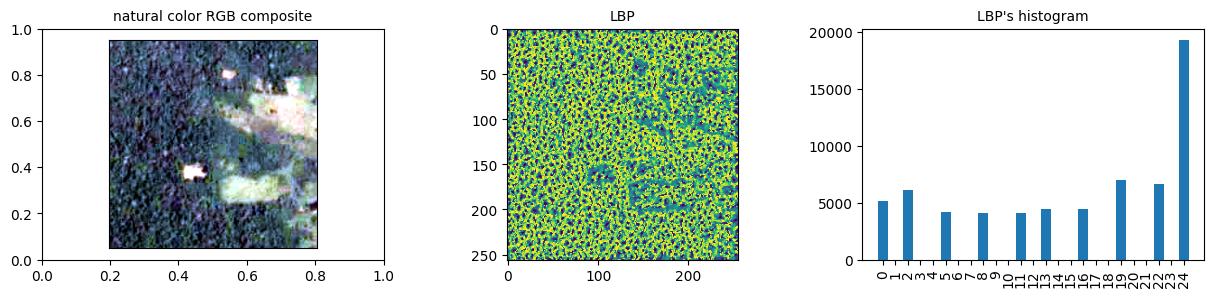

In [19]:
rows = 1
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15,3))

# ax0 
image_na = np.array(Image.open(input_images[0]))
image_na = np.moveaxis(image_na, [2], [0])
ep.plot_rgb(image_na, rgb=(0, 1, 2), ax=axes[0].inset_axes((0.05, 0.05, 0.9, 0.9)), stretch=True)
axes[0].set_title('natural color RGB composite', fontsize=10)

# ax1
lbp_na = lbp_train_images[0].reshape(256, 256)
axes[1].imshow(lbp_na, cmap='viridis')
axes[1].set_title('LBP', fontsize=10)

# ax2

axes[2].bar(['bin ' + str(i) for i in range(25)], lbp_train_histograms_na[0,:])
axes[2].set_xticklabels(axes[2].get_xticks(), rotation = 90)
axes[2].set_title("LBP's histogram", fontsize=10)

plt.show();

### Step 2: Stratified training/validation data split

The goal of this step is to perform 5-fold cross-validation - divide the training set 5 times into two parts - training and validation. The EDA (previous notebook) revealed that the dataset is rather diverse, so in order to make both parts representative, stratified splits will be made. I will use the previously prepared *labels* DataFrame as a starting point: 

In [20]:
labels_df = pd.read_csv('train_labels_processed.csv')

In [21]:
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down,num_labels
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,4
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,5


Next, I add a new column called *weather* to treat the 4 *atmospheric conditions* categories as mutually exclusive:

In [22]:
labels_df['weather'] = labels_df[["haze", "clear", "cloudy", "partly_cloudy"]].idxmax(axis=1)

In [23]:
labels_df['weather_nb'] = labels_df['weather'].apply(lambda x: 0 if x == 'clear' 
                                                     else 1 if x == 'partly_cloudy' 
                                                     else 2 if x == 'cloudy'
                                                     else 3)

To clean the DataFrame, I also delete the unnecessary columns:

In [24]:
labels_df = labels_df.drop(["tags", "num_labels", "haze", "clear", "cloudy", "partly_cloudy", "weather"], axis=1)

I would like to make splits as representative as possible. In order to achieve this I will create a new column called *labelconcat* that is the result of concatenating all category labeles (all columns except of *image_name*) for each row: 

In [25]:
cols_to_concat = list(labels_df.columns)[1:]
print(*cols_to_concat, sep=', ')

primary, agriculture, water, habitation, road, cultivation, slash_burn, conventional_mine, bare_ground, artisinal_mine, blooming, selective_logging, blow_down, weather_nb


In [26]:
labels_df["labelconcat"] = labels_df[cols_to_concat].apply(lambda row: "".join(map(str, row)), axis=1)

In [27]:
labels_df.head()

,image_name,primary,agriculture,water,habitation,road,cultivation,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down,weather_nb,labelconcat
0,train_0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,10000000000003
1,train_1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,11100000000000
2,train_2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10000000000000
3,train_3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10000000000000
4,train_4,1,1,0,1,1,0,0,0,0,0,0,0,0,0,11011000000000


In [28]:
labels_df["labelconcat"].value_counts()

10000000000000    13636
10000000000001     3630
00000000000002     2089
10100000000000     1850
11001000000000     1680
                  ...  
10000000010001        1
01101000000001        1
11111000000100        1
11000100101101        1
10011110000000        1
Name: labelconcat, Length: 410, dtype: int64

Printing the number of rows having the unique *labelconcat* values reveals that some of them characterize only one row. I will group the in the *rare* category and collect the final *labelconcat* values in the column named *labelconcat2*:

In [29]:
label_counts_dict = dict(labels_df["labelconcat"].value_counts())
labels_df["labelconcat2"] = labels_df["labelconcat"].apply(lambda x: 'rare' if label_counts_dict[x] == 1 else x)

In [30]:
labels_df.loc[7:10, :]

,image_name,primary,agriculture,water,habitation,road,cultivation,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down,weather_nb,labelconcat,labelconcat2
7,train_7,1,0,0,0,0,0,0,0,0,0,0,0,0,3,10000000000003,10000000000003
8,train_8,1,1,0,0,0,1,0,0,0,0,0,0,0,0,11000100000000,11000100000000
9,train_9,1,1,0,0,1,1,0,0,0,0,0,0,0,0,11001100000000,11001100000000
10,train_10,1,1,1,0,0,0,1,0,0,0,0,0,0,0,11100010000000,rare


Finally, I will use Scikit-learn's *StratifiedShuffleSplit* algorithm to divide the training data into two parts. I will save the results as *.csv* files:

In [31]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

In [32]:
for i, (train_index, val_index) in enumerate(split.split(labels_df, labels_df['labelconcat2'])):
    strat_train_set = labels_df.loc[train_index]
    strat_val_set = labels_df.loc[val_index]
    strat_train_set.to_csv('train_split_' + str(i) + '.csv', index=False)
    strat_val_set.to_csv('val_split_' + str(i) + '.csv', index=False)

### Step 3: Classification

As the first step X and y - inputs to the classification, need to be prepared. Separate X, y pairs need to be created for each of the five random splits and train/val parts. Additionally, two features arrays need to be stacked to create one matrix:

In [33]:
X = np.hstack((ipca_train_histograms_na, lbp_train_histograms_na))

In [34]:
X.shape # samples, features

(40479, 50)

In [35]:
X_dict = {}
y_dict = {}

In [36]:
def get_key(val):
    for key, value in image_id_dict.items():
        if val == value:
            return key

In [37]:
for split in range(5):
    for part in ['train', 'val']:
        # train/val df
        df = pd.read_csv(part + '_split_' + str(split) + '.csv')
        # finding images' indices
        image_indices = []
        for iname in df['image_name'].to_list():
            image_indices.append(get_key(iname))
        # indexing X array using the indices
        X_part_split = X[image_indices]
        # filling dicts
        X_dict['X_' + part + '_split_' + str(split)] = X_part_split
        df = df.drop(["image_name", "labelconcat", "labelconcat2"], axis=1)
        y_dict['y_' + part + '_split_' + str(split)] = df.to_numpy()

Having the input data ready, classifications can be performed:

In [38]:
y_pred_dict = {}

In [39]:
classifiers = {'MOC Logistic Regression': MultiOutputClassifier(estimator=LogisticRegression(max_iter = 10000), n_jobs=-1),
               'MOC Random Forest': MultiOutputClassifier(estimator=RandomForestClassifier(), n_jobs=-1),
               'MOC kNN': MultiOutputClassifier(estimator=KNeighborsClassifier(), n_jobs=-1), 
               'CC Random Forest': ClassifierChain(base_estimator=RandomForestClassifier()),
               'CC kNN': ClassifierChain(base_estimator=KNeighborsClassifier())
              }

In [40]:
for clf in classifiers:
    for split in range(5):
        # finding training X, y
        X_train = X_dict['X_train_split_' + str(split)]
        y_train = y_dict['y_train_split_' + str(split)]
        # training
        start_time = time.time()
        clf_obj = classifiers[clf].fit(X_train, y_train)
        end_time = time.time()
        baseline_metrics_df.loc[clf, 'train_time [min]'] += round((end_time - start_time)/60, 2)
        # finding validation X
        X_val = X_dict['X_val_split_' + str(split)]
        # predicition
        start_time = time.time()
        y_pred = clf_obj.predict(X_val)
        end_time = time.time()
        baseline_metrics_df.loc[clf, 'pred_time [min]'] += round((end_time - start_time)/60, 2)
        y_pred_dict['y_pred_split_' + str(split) + '_' + clf] = y_pred
        print(f"{clf} & {split} done")

MOC Logistic Regression & 0 done
MOC Logistic Regression & 1 done
MOC Logistic Regression & 2 done
MOC Logistic Regression & 3 done
MOC Logistic Regression & 4 done
MOC Random Forest & 0 done
MOC Random Forest & 1 done
MOC Random Forest & 2 done
MOC Random Forest & 3 done
MOC Random Forest & 4 done
MOC kNN & 0 done
MOC kNN & 1 done
MOC kNN & 2 done
MOC kNN & 3 done
MOC kNN & 4 done
CC Random Forest & 0 done
CC Random Forest & 1 done
CC Random Forest & 2 done
CC Random Forest & 3 done
CC Random Forest & 4 done
CC kNN & 0 done
CC kNN & 1 done
CC kNN & 2 done
CC kNN & 3 done
CC kNN & 4 done


In [41]:
with open('y_pred_dict.pickle', 'wb') as file:
    pickle.dump(y_pred_dict, file)

In [42]:
baseline_metrics_df 

,fe_color_time [min],fe_texture_time [min],train_time [min],pred_time [min]
MOC Logistic Regression,85.63,29.73,2.92,0.00
MOC Random Forest,85.63,29.73,1.63,0.17
MOC kNN,85.63,29.73,0.12,5.07
CC Random Forest,85.63,29.73,8.71,0.19
CC kNN,85.63,29.73,0.00,9.85


One can observe that calculating the color histogram took a bit more time than the texture-related one. It is not a surprise as PCA is a more complex transformation than Local Binary Pattern. Moving to the next step, it can be noted that kNN was the algorithm fastest to train and slowest to infer. The opposite is true for Random Forest.

In [44]:
baseline_metrics_df.to_csv('baseline_metrics.csv')

### Step 4: Accuracy assessment

The last step of the process is to assess the accuracy of the six tested approaches. The description of the Kaggle's challenge [2] informs that the outcomes will be evaluated using F-score with Beta parameter equal to 2 (therefore putting more weight to recall than to the precision). For this reason I will use the same metric here. Before doing so, I however need to transform the values of *weather_nb* column back to four binary columns in order to frame it again as a multilabel problem:

In [116]:
y_val_mlb_dict = {} # true val framed as multilabel problem
y_pred_mlb_dict = {} # pred (val) framed as multilabel problem

In [117]:
def tranform_col_to_binary(arr:np.array, col_index:int) -> np.array:
    """Return np.Array with its selected column transformed to a set of binary columns."""
    
    # creating new cols
    encoder = OneHotEncoder(sparse=False)
    selected_col = arr[:, col_index].reshape(-1, 1)
    new_cols = encoder.fit_transform(selected_col)
    
    # forming the final arr
    arr = np.delete(arr, col_index, axis=1)
    arr = np.hstack([arr, new_cols])
    return arr

In [118]:
for y in y_dict:
    if 'val' in y:
        y_val_mlb_dict[y] = tranform_col_to_binary(y_dict[y], -1)

In [119]:
for y in y_pred_dict:
    y_pred_mlb_dict[y] = tranform_col_to_binary(y_pred_dict[y], -1)

Having all labels in the binary format, I can calculate the F-scores:

In [120]:
column_names = ['primary', 'agriculture', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'conventional_mine', 
                    'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down',
                    'clear', 'partly_cloudy', 'cloudy', 'haze']

fscore_col_df = pd.DataFrame(columns=column_names,
                             index=['MOC Logistic Regression', 'MOC Random Forest', 'MOC kNN', 
                                    'CC Random Forest', 'CC kNN'])

In [121]:
for clf in classifiers:
    
    fscore_split = []
    fscore_col_split = []
    
    for split in range(5):
        y_true = y_val_mlb_dict['y_val_split_' + str(split)]
        y_pred = y_pred_mlb_dict['y_pred_split_' + str(split) + '_' + clf]
        fscore_split.append(round(fbeta_score(y_true, y_pred, average='samples', beta=2), 2))
        fscore_col_split.append(fbeta_score(y_true, y_pred, average=None, beta=2).tolist())
    
    fscore_col_df.loc[clf, :] = np.round(np.mean(np.array(fscore_col_split), axis=0), 2).tolist()
    print(f"{clf}'s overall F-score statistics: min:{min(fscore_split)}, mean:{round(sum(fscore_split)/len(fscore_split), 2)}, max:{max(fscore_split)}")

MOC Logistic Regression's overall F-score statistics: min:0.75, mean:0.75, max:0.76
MOC Random Forest's overall F-score statistics: min:0.83, mean:0.83, max:0.84
MOC kNN's overall F-score statistics: min:0.78, mean:0.78, max:0.79
CC Random Forest's overall F-score statistics: min:0.83, mean:0.83, max:0.84
CC kNN's overall F-score statistics: min:0.78, mean:0.78, max:0.79


The overall F-scores - the ones computed separately for all samples and averaged, are quite high. They range between 0.75 and 0.84. In order to evaluate the results more precisely, I can also show F-score values per label:

In [122]:
fscore_col_df = fscore_col_df * 100 # seaborn seem not accept floating values

In [123]:
fscore_col_df = fscore_col_df.astype(int)

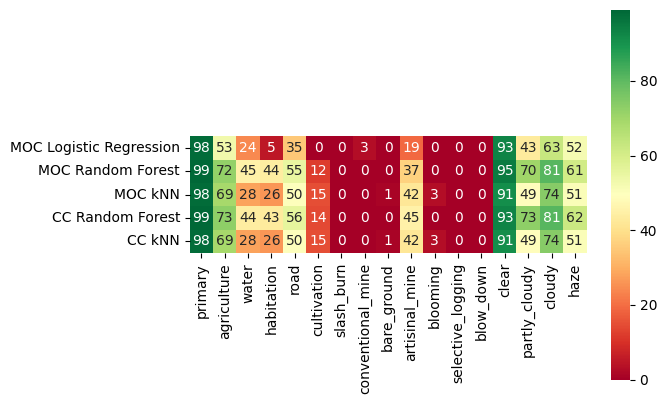

In [131]:
sns.heatmap(fscore_col_df, cmap='RdYlGn', annot=True, square=True);

💡💭 <b> Conclusions: </b>
- Random Forest works best among all algorithms, while Logistic Regression performs the worst
- exploiting dependencies between outputs (CC) doesn't appear to significantly improve accuracy; it only helped with the label 'artisinal_mine'
- huge differences in accuracy can be observed between labels; in general most accurate are the ones which had a lot of samples related with them e.g. 'primary' and 'clear' (as no class balancing strategy was applied); other possible factors include the uniqueness of the spectral signal ('artisinal_mine') and non-cooccurence with other labels ('cloudy') 
- labels related to smaller, more complex objects obtained a very low accuracy as they weren't characterized precisely enough by the histogram values; one way to improve this is to further develop the presented approach by preparing a customized feature engineering, using more complex algorithms etc. This is very time consuming, so instead CNNs will be tested in the next step (next notebook)